In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
# Future warning fix:
# /Users/equon/anaconda3/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

To generate *regular* data for use with microscale profile assimilation, holes in data are typically filled using natural neighbor interpolation. This requires an additional python library which may be installed with `pip install naturalneighbor`

In [5]:
import naturalneighbor

`a2e-mmc` modules

In [6]:
# manually add a2e-mmc repos to PYTHONPATH if needed
import sys
module_path = '/home/ckaul/DriesNotebook'
if module_path not in sys.path:
    sys.path.append(module_path)

In [7]:
from mmctools.dataloaders import read_dir
from mmctools.measurements.radar import profiler
from mmctools.helper_functions import calc_uv
from mmctools.plotting import plot_timeheight, plot_profile

/home/ckaul/.conda-envs/my_env/lib/python3.7/site-packages/xarray/core/merge.py:17: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  PANDAS_TYPES = (pd.Series, pd.DataFrame, pd.Panel)


# Process TTU Radar Data
written by [Eliot Quon](mailto:eliot.quon@nrel.gov)

To generate driving data for MMC diurnal study. This notebook depends on:
- 10-min tower data generated by `process_TTU_tower.ipynb`
- cutoff value for SNR; when the SNR for one or more beams falls below this threshold, then the measured wind speed and direction will be thrown out (i.e., set to nan)

In [8]:
# analysis range
starttime = '2013-11-08 12:00'
endtime = '2013-11-09 12:02' # extend past 12:00 to include one more snapshot

In [9]:
# 10-min tower data generated by `process_TTU_tower.ipynb`
towerdata = '/projects/mmcpnnl/ckaul/mmc_tower/ProcessedData/TTU_tilt_corrected_20131108-09_10min.csv'

In [10]:
# data manually downloaded from DAP
radardir = '/projects/mmcpnnl/ckaul/mmc_radar/mmc.radar.z01.00'

In [11]:
# for further QC-ing the radar data
# e.g., for lidars, typically -22: https://journals.ametsoc.org/doi/full/10.1175/JTECH-D-11-00033.1
SNR_fields = ['SNR.0','SNR.1','SNR.2','SNR.3']
SNR_cutoff = -22.5

In [12]:
# output data for further analyses
winds_output = '/projects/mmcpnnl/ckaul/mmc_radar/ProcessedData/radar_winds.z01.00_20131108.csv' # or None
rass_output = '/projects/mmcpnnl/ckaul/mmc_radar/ProcessedData/radar_rass.z01.00_20131108.csv' # or None
combined_output = '/projects/mmcpnnl/ckaul/mmc_swift_combined/ProcessedData/TTU_obs_QC_20131108.csv' # all obs: TTU tower data, QC'd radar data
NNinterp_output = '/projects/mmcpnnl/ckaul/mmc_swift_combined/ProcessedData/TTU_obs_NNinterp_20131108.csv' # fully gridded time-height data with all obs

In [13]:
# where to save figures
fig_output = '/projects/mmcpnnl/ckaul/mmc_swift_combined/figures'
if not os.path.isdir(fig_output):
    os.makedirs(fig_output)

## Read data
Note: According to the [DAP](https://a2e.energy.gov/data/mmc/radar.z01.00), the timestamp is:
> Averaged at interval of `20 UTC` at the **start** of the bin

In contrast, pandas rolling/resample operations place the timestamp at the **end** of the sampling interval.

In [14]:
# period of interest
starttime = pd.to_datetime(starttime)
endtime = pd.to_datetime(endtime)

In [15]:
freq_20min = pd.date_range(start=starttime,end=endtime,freq='20min')

### radar: WINDS output

In [16]:
winds_scantypes = []
winds = read_dir(radardir, file_filter='*_w*.cns',
                 reader=profiler,
                 # profiler parameters:
                 scans=None, # read all scans
                 read_scan_properties=winds_scantypes,
                 check_na=['SPD','DIR','SNR'], na_values=999999,
                 #verbose=True,
                )
winds = winds.reset_index()
winds['height'] *= 1000 # [m]
if winds_output is not None:
    winds.set_index(['datetime','height']).to_csv(winds_output)

In [17]:
# standardize variable names
winds = winds.rename(columns={
    'SPD': 'wspd',
    'DIR': 'wdir',
})

3 different scans found in the data during the two days; only scan0 and scan1 were used during the period of interest, alternating every ~10 min

In [18]:
winds_scantypes

[{'station': 'Reese Center',
  'data_format': 'WINDS    rev 5.1',
  'consensus_avg_time_min': 16,
  'num_beams': 4,
  'num_range_gates': 30,
  'beam:reqd_records_for_consensus': [4, 4, 4, 4],
  'beam:tot_num_records': [6, 6, 6, 6],
  'beam:consensus_window_size_m/s': [3.0, 3.0, 3.0, 3.0],
  'num_coherent_integrations': [132, 999999],
  'num_spectral_averages': [42, 999999],
  'pulse_width_ns': [400, 999999],
  'inner_pulse_period_ms': [31, 999999],
  'fullscale_doppler_value_m/s': [20.0, 999999.0],
  'vertical_correction_to_obliques': True,
  'delay_to_first_gate_ns': [2850, 999999],
  'num_gates': [30, 999999],
  'gate_spacing_ns': [400, 999999],
  'beam:azimuth_deg': [90.0, 0.0, 270.0, 180.0],
  'beam:elevation_deg': [66.4, 66.4, 66.4, 66.4]},
 {'station': 'Reese Center',
  'data_format': 'WINDS    rev 5.1',
  'consensus_avg_time_min': 15,
  'num_beams': 4,
  'num_range_gates': 30,
  'beam:reqd_records_for_consensus': [3, 3, 3, 4],
  'beam:tot_num_records': [5, 5, 5, 6],
  'beam:cons

range gates for the 3 scans

In [19]:
for itype,scaninfo in enumerate(winds_scantypes):
    print('scan',itype, winds.loc[winds['scan_type']==itype,'height'].unique())

scan 0 [ 151.  206.  261.  316.  371.  426.  481.  536.  590.  645.  700.  755.
  810.  865.  920.  975. 1030. 1085. 1140. 1195. 1250. 1305. 1359. 1414.
 1469. 1524. 1579. 1634. 1689. 1744.]
scan 1 [ 611.  803.  996. 1188. 1380. 1572. 1765. 1957. 2149. 2341. 2534. 2726.
 2918. 3110. 3303. 3495. 3687. 3879. 4072. 4264. 4456. 4648. 4841. 5033.
 5225. 5417. 5610. 5802. 5994. 6186.]
scan 2 [ 611.  803.  996. 1188. 1380. 1572. 1765. 1957. 2149. 2341. 2534. 2726.
 2918. 3110. 3303. 3495. 3687. 3879. 4072. 4264. 4456. 4648. 4841. 5033.
 5225. 5417. 5610. 5802. 5994. 6186.]


### radar: RASS output

In [20]:
rass_scantypes = []
rass = read_dir(radardir, file_filter='*_t*.cns',
                reader=profiler,
                # profiler parameters:
                scans=None, # read all scans
                read_scan_properties=rass_scantypes,
                check_na=['T','Tc','W','SNR'], na_values=999999,
                #verbose=True,
            )
rass = rass.reset_index()
rass['height'] *= 1000 # [m]
if rass_output is not None:
    rass.set_index(['datetime','height']).to_csv(rass_output)

In [21]:
rass_scantypes

[{'station': 'Reese Center',
  'data_format': 'RASS    rev 5.1',
  'consensus_avg_time_min': 3,
  'num_beams': 1,
  'num_range_gates': 25,
  'beam:reqd_records_for_consensus': [9],
  'beam:tot_num_records': [14],
  'beam:consensus_window_size_m/s': [3.0],
  'num_coherent_integrations': 9,
  'num_spectral_averages': 28,
  'pulse_width_ns': 400,
  'inner_pulse_period_ms': 23,
  'fullscale_doppler_value_m/s': 395.7,
  'vertical_correction_to_obliques': 'n/a',
  'delay_to_first_gate_ns': 2850,
  'num_gates': 25,
  'gate_spacing_ns': 400,
  'beam:azimuth_deg': [0.0],
  'beam:elevation_deg': [90.0]},
 {'station': 'Reese Center',
  'data_format': 'RASS    rev 5.1',
  'consensus_avg_time_min': 3,
  'num_beams': 1,
  'num_range_gates': 25,
  'beam:reqd_records_for_consensus': [8],
  'beam:tot_num_records': [13],
  'beam:consensus_window_size_m/s': [3.0],
  'num_coherent_integrations': 9,
  'num_spectral_averages': 28,
  'pulse_width_ns': 400,
  'inner_pulse_period_ms': 23,
  'fullscale_doppler_

In [22]:
for itype,scaninfo in enumerate(rass_scantypes):
    print('scan',itype, rass.loc[rass['scan_type']==itype,'height'].unique())

scan 0 [ 165.  225.  285.  345.  405.  465.  524.  584.  644.  704.  764.  824.
  884.  944. 1004. 1064. 1124. 1184. 1244. 1304. 1364. 1424. 1484. 1543.
 1603.]
scan 1 [ 165.  225.  285.  345.  405.  465.  524.  584.  644.  704.  764.  824.
  884.  944. 1004. 1064. 1124. 1184. 1244. 1304. 1364. 1424. 1484. 1543.
 1603.]
scan 2 [ 165.  225.  285.  345.  405.  465.  524.  584.  644.  704.  764.  824.
  884.  944. 1004. 1064. 1124. 1184. 1244. 1304. 1364. 1424. 1484. 1543.
 1603.]


In [23]:
inrange = (rass['datetime'] >= starttime) & (rass['datetime'] <= endtime)
rass = rass.loc[inrange]
rass = rass.set_index(['datetime','height'])

### 200-m tower
reference data near the ground

Note: to line up with radar data, shift timestamps from *end* of 10-min interval to the *beginning*

In [24]:
tower = pd.read_csv(towerdata,parse_dates=['datetime'])

In [25]:
# shift timestamps by 10-min to match radar timestamps
tower['datetime'] -= pd.to_timedelta('10min')

In [26]:
inrange = (tower['datetime'] >= starttime) & (tower['datetime'] <= endtime)
tower = tower.loc[inrange]
tower = tower.set_index(['datetime','height'])

In [27]:
tower['scan_type'] = -1 

## Analyze scan "0" (short range)

In [28]:
scan0 = winds.loc[winds['scan_type']==0]
inrange = (scan0['datetime'] >= starttime) & (scan0['datetime'] <= endtime)
scan0 = scan0.loc[inrange]
scan0 = scan0.set_index(['datetime','height'])

In [29]:
assert len(scan0.index.levels[0])==len(freq_20min)
scan0.index.levels[0]

DatetimeIndex(['2013-11-08 12:00:00', '2013-11-08 12:20:04',
               '2013-11-08 12:40:07', '2013-11-08 13:00:11',
               '2013-11-08 13:20:02', '2013-11-08 13:40:05',
               '2013-11-08 14:00:09', '2013-11-08 14:20:01',
               '2013-11-08 14:40:04', '2013-11-08 15:00:08',
               '2013-11-08 15:20:11', '2013-11-08 15:40:03',
               '2013-11-08 16:00:06', '2013-11-08 16:20:10',
               '2013-11-08 16:40:02', '2013-11-08 17:00:05',
               '2013-11-08 17:20:09', '2013-11-08 17:40:00',
               '2013-11-08 18:00:04', '2013-11-08 18:20:08',
               '2013-11-08 18:40:00', '2013-11-08 19:00:04',
               '2013-11-08 19:20:07', '2013-11-08 19:40:11',
               '2013-11-08 20:00:03', '2013-11-08 20:20:07',
               '2013-11-08 20:40:11', '2013-11-08 21:00:03',
               '2013-11-08 21:20:07', '2013-11-08 21:40:11',
               '2013-11-08 22:00:02', '2013-11-08 22:20:06',
               '2013-11-

In [30]:
# force scan timestamps to line up exactly at 20-min intervals by overwriting the index
scan0_20min = scan0[['wspd','wdir','scan_type']+SNR_fields].unstack().set_index(freq_20min).stack()

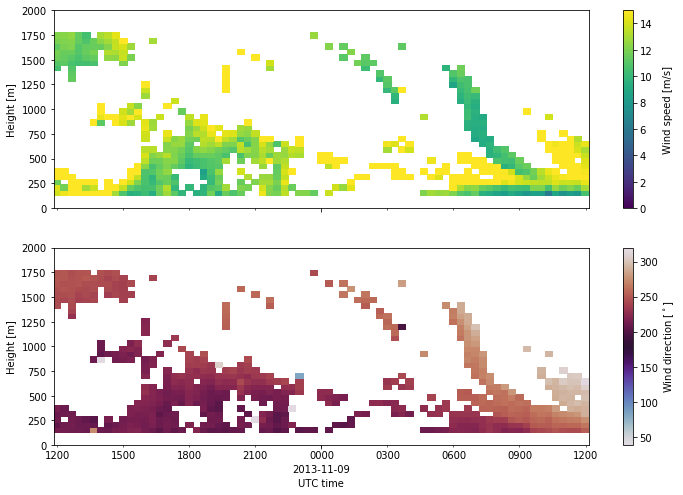

In [31]:
fig,ax,cbars = plot_timeheight(scan0,
                               fields=['wspd','wdir'],
                               fieldlimits={'wspd':(0,15)},
                               heightlimits=(0,2000),
                              )
fig.savefig(os.path.join(fig_output,'scan0_20min.png'),
            dpi=150,bbox_inches='tight')

## Analyze scan "1" (long range)

In [32]:
scan1 = winds.loc[winds['scan_type']==1]
inrange = (scan1['datetime'] >= starttime) & (scan1['datetime'] <= endtime)
scan1 = scan1.loc[inrange]
scan1 = scan1.set_index(['datetime','height'])

In [33]:
assert len(scan1.index.levels[0])==len(freq_20min)
scan1.index.levels[0]

DatetimeIndex(['2013-11-08 12:01:35', '2013-11-08 12:21:39',
               '2013-11-08 12:41:42', '2013-11-08 13:01:46',
               '2013-11-08 13:21:37', '2013-11-08 13:41:40',
               '2013-11-08 14:01:44', '2013-11-08 14:21:36',
               '2013-11-08 14:41:39', '2013-11-08 15:01:43',
               '2013-11-08 15:21:46', '2013-11-08 15:41:38',
               '2013-11-08 16:01:42', '2013-11-08 16:21:45',
               '2013-11-08 16:41:37', '2013-11-08 17:01:40',
               '2013-11-08 17:21:44', '2013-11-08 17:41:35',
               '2013-11-08 18:01:39', '2013-11-08 18:21:43',
               '2013-11-08 18:41:35', '2013-11-08 19:01:39',
               '2013-11-08 19:21:42', '2013-11-08 19:41:46',
               '2013-11-08 20:01:38', '2013-11-08 20:21:42',
               '2013-11-08 20:41:46', '2013-11-08 21:01:38',
               '2013-11-08 21:21:42', '2013-11-08 21:41:46',
               '2013-11-08 22:01:37', '2013-11-08 22:21:41',
               '2013-11-

In [34]:
# neglect ~1 min offset between scan0 and scan1
scan1_20min = scan1[['wspd','wdir','scan_type']+SNR_fields].unstack().set_index(freq_20min).stack()

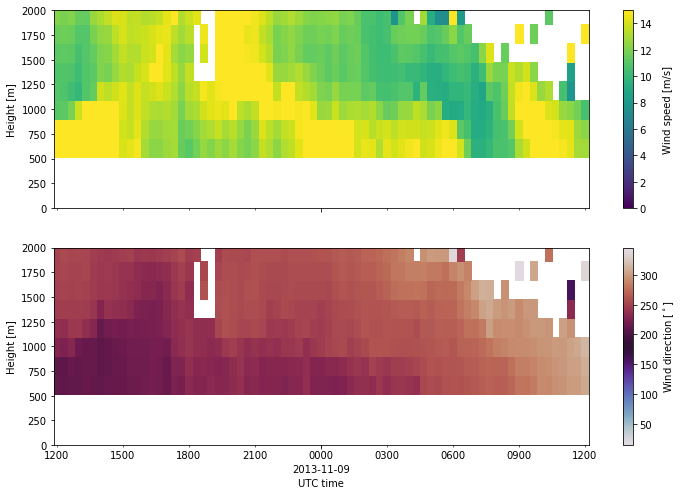

In [35]:
fig,ax,cbars = plot_timeheight(scan1,
                               fields=['wspd','wdir'],
                               fieldlimits={'wspd':(0,15)},
                               heightlimits=(0,2000), # heightlimits=(0,3000),
                              )
fig.savefig(os.path.join(fig_output,'scan1_20min.png'),
            dpi=150,bbox_inches='tight')

at this point, the `scan_type` flag will indicate:
- -1: tower data, up to 200 m
- 0: radar scan "0", up to 1744 m
- 1: radar scan "1", up to 6186 m

## Analyze wind data SNR

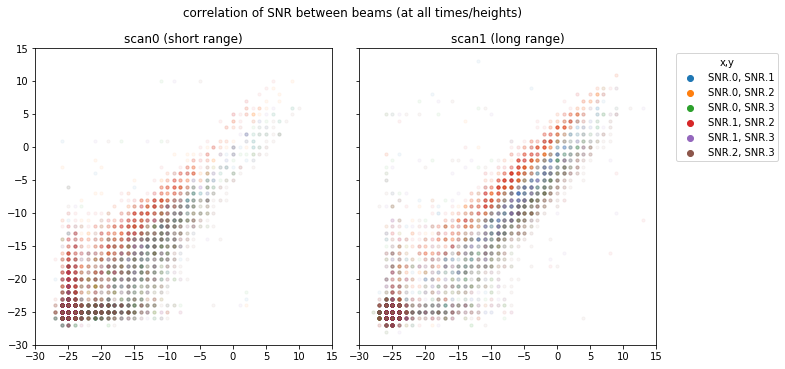

In [36]:
fig,ax = plt.subplots(ncols=2,sharex=True,sharey=True,figsize=(11,5.5))
styles = dict(s=10, alpha=0.05)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
idx = 0
for i in range(3):
    for j in range(i+1,4):
        color = colors[idx]
        ax[0].scatter(scan0[SNR_fields[i]], scan0[SNR_fields[j]], c=color, label='', **styles)
        ax[1].scatter(scan1[SNR_fields[i]], scan1[SNR_fields[j]], c=color, label='', **styles)
        # legend hack
        ax[1].scatter(50,50, c=color, label='{:s}, {:s}'.format(SNR_fields[i], SNR_fields[j]))
        idx += 1
ax[0].axis('scaled')
ax[1].axis('scaled')
ax[1].set_xlim((-30,15))
ax[1].set_ylim((-30,15))
ax[0].set_title('scan0 (short range)')
ax[1].set_title('scan1 (long range)')
ax[1].legend(loc='upper left',bbox_to_anchor=(1.05,1),title='x,y')
fig.suptitle('correlation of SNR between beams (at all times/heights)',x=0.45)
plt.tight_layout()

Text(0.5, 1.0, 'scan1 (long range)')

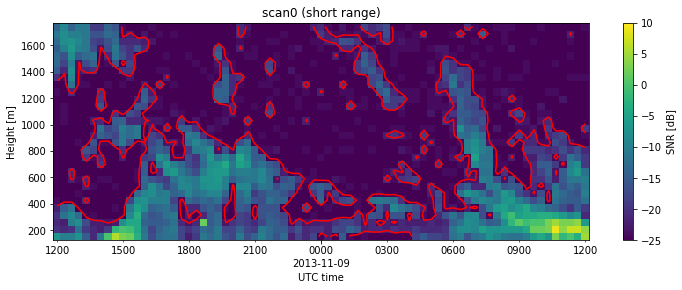

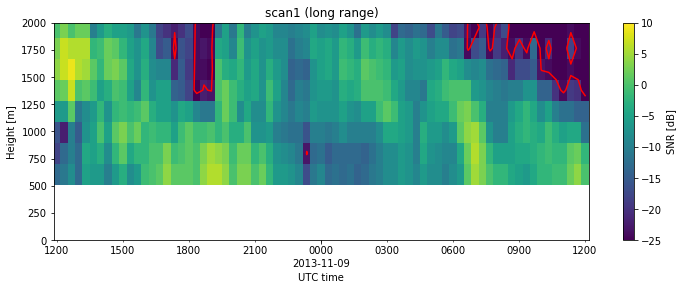

In [37]:
plotfield = 'SNR.0'
vmin,vmax = -25, 10

fig,ax,cbars = plot_timeheight(scan0, fields=plotfield,
                               fieldlabels='SNR [dB]',
                               fieldlimits=(vmin,vmax),)
tt,zz = np.meshgrid(scan0.index.levels[0], scan0.index.levels[1], indexing='ij')
ax.contour(tt,zz,scan0[plotfield].unstack(), levels=[SNR_cutoff], colors='r', linestyles='-')
ax.set_title('scan0 (short range)')

fig,ax,cbars = plot_timeheight(scan1, fields=plotfield,
                               fieldlabels='SNR [dB]',
                               fieldlimits=(vmin,vmax),
                               heightlimits=(0,2000))
tt,zz = np.meshgrid(scan1.index.levels[0], scan1.index.levels[1], indexing='ij')
ax.contour(tt,zz,scan1[plotfield].unstack(), levels=[SNR_cutoff], colors='r', linestyles='-')
ax.set_title('scan1 (long range)')

IndexError: tuple index out of range

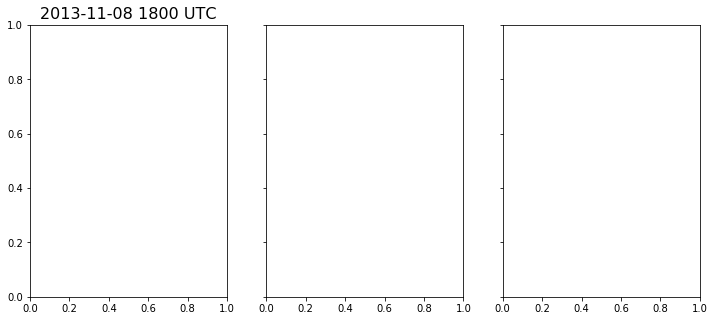

In [38]:
times_of_interest = ['2013-11-08 18:00',
                     '2013-11-08 22:00',
                     '2013-11-09 06:00']
vmin,vmax = -30,10

# plot SNR.0
fig,ax = plot_profile({'scan0 (short range)':scan0_20min,
                       'scan1 (long range)':scan1_20min },
                      fields='SNR.0',
                      times=times_of_interest,
                      stack_by_datasets=True,
                      fieldlimits=(vmin,vmax),
                      heightlimits=(0,2000))
# now, overlay SNR.[1-3]
for plotvar in SNR_fields[1:]:
    plot_profile({'scan0 (short range)':scan0_20min,
                  'scan1 (long range)':scan1_20min },
                 fields=plotvar,
                 times=times_of_interest,
                 stack_by_datasets=True,
                 fieldlimits=(vmin,vmax),
                 heightlimits=(0,2000),
                 fig=fig,ax=ax,showlegend=False)
for axi in ax:
    axi.set_xlabel('SNR [dB]')
    axi.axvspan(-30,SNR_cutoff,color='0.8')

## Combine all data

In [39]:
output_fields = ['wspd','wdir','scan_type']

### overlay plot

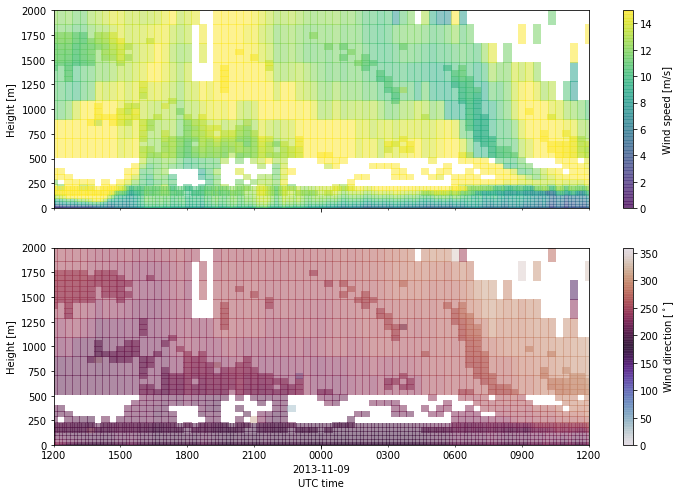

In [40]:
fig,ax,cbars = plot_timeheight(scan0,
                               fields=['wspd','wdir'],
                               fieldlimits={'wspd':(0,15),'wdir':(0,360)},
                               heightlimits=(0,2000),
                               timelimits=(starttime,endtime),
                               alpha=0.5,
                              )
_,_,_ = plot_timeheight(scan1,
                        fields=['wspd','wdir'],
                        fieldlimits={'wspd':(0,15),'wdir':(0,360)},
                        heightlimits=(0,2000),
                        alpha=0.5,
                        fig=fig,ax=ax,showcolorbars=False,
                       )
_,_,_ = plot_timeheight(tower,
                        fields=['wspd','wdir'],
                        fieldlimits={'wspd':(0,15),'wdir':(0,360)},
                        heightlimits=(0,2000),
                        alpha=0.5,
                        fig=fig,ax=ax,showcolorbars=False,
                       )
fig.savefig(os.path.join(fig_output,'all_data_10min.png'),
            dpi=150,bbox_inches='tight')

### filter out low SNR data

In [41]:
below_threshold = scan0_20min[SNR_fields].apply(lambda SNR: np.any(SNR < SNR_cutoff), axis=1)
scan0_20min_qc = scan0_20min[output_fields].copy()
scan0_20min_qc.loc[below_threshold, ['wspd','wdir']] = np.nan

In [42]:
below_threshold = scan1_20min[SNR_fields].apply(lambda SNR: np.any(SNR < SNR_cutoff), axis=1)
scan1_20min_qc = scan1_20min[output_fields].copy()
scan1_20min_qc.loc[below_threshold, ['wspd','wdir']] = np.nan

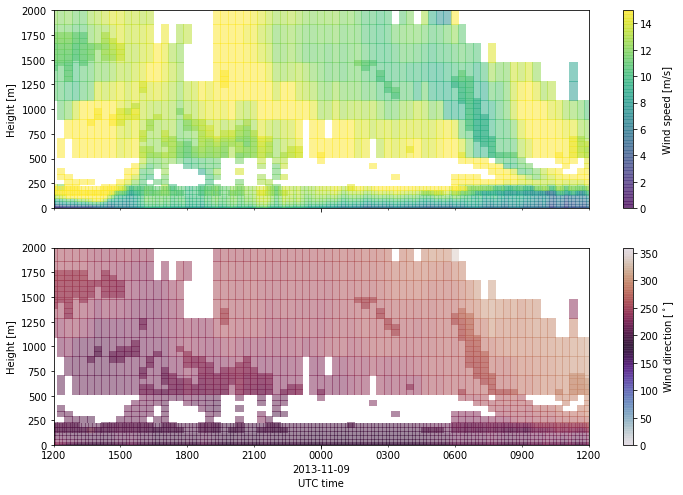

In [43]:
fig,ax,cbars = plot_timeheight(scan0_20min_qc,
                               fields=['wspd','wdir'],
                               fieldlimits={'wspd':(0,15),'wdir':(0,360)},
                               timelimits=(starttime,endtime),
                               heightlimits=(0,2000),
                               alpha=0.5,
                              )
_,_,_ = plot_timeheight(scan1_20min_qc,
                        fields=['wspd','wdir'],
                        fieldlimits={'wspd':(0,15),'wdir':(0,360)},
                        heightlimits=(0,2000),
                        alpha=0.5,
                        fig=fig,ax=ax,showcolorbars=False,
                       )
_,_,_ = plot_timeheight(tower,
                        fields=['wspd','wdir'],
                        fieldlimits={'wspd':(0,15),'wdir':(0,360)},
                        heightlimits=(0,2000),
                        alpha=0.5,
                        fig=fig,ax=ax,showcolorbars=False,
                       )
fig.savefig(os.path.join(fig_output,'all_data_QCd_10min.png'),
            dpi=150,bbox_inches='tight')

### resample scans
to 10-min to match tower data

In [44]:
# interpolate 
# - default method: "linear", assuming equally spaced data points
# - limit area: "inside" to not extrapolate unbounded nan regions
# - NOTE: holes are too big to fill!
scan0_10min = scan0_20min_qc[output_fields].unstack()
scan0_10min = scan0_10min.resample('10min').interpolate(method='linear',limit=1,limit_area='inside').stack()

In [45]:
scan1_10min = scan1_20min_qc[output_fields].unstack()
scan1_10min = scan1_10min.resample('10min').interpolate(method='linear',limit=1,limit_area='inside').stack()

In [46]:
tower_10min = tower[output_fields]

In [47]:
# now everything is at 10-min intervals
alldata = pd.concat([scan0_10min, scan1_10min, tower_10min]).sort_index().reset_index()
alldata = alldata.rename(columns={'level_0':'datetime'})

In [48]:
# calculate an integer time index for griddata
toffset = pd.to_timedelta('10min')
alldata['t_index'] = (alldata['datetime'] - starttime) / toffset

In [49]:
alldata

,datetime,height,wspd,wdir,scan_type,t_index
0,2013-11-08 12:00:00,0.9,1.225746,219.005685,-1.0,0.0
1,2013-11-08 12:00:00,2.4,1.772110,225.353123,-1.0,0.0
2,2013-11-08 12:00:00,4.0,2.046332,229.267605,-1.0,0.0
3,2013-11-08 12:00:00,10.1,2.979477,233.780026,-1.0,0.0
4,2013-11-08 12:00:00,16.8,3.944645,239.036134,-1.0,0.0
5,2013-11-08 12:00:00,47.3,7.112991,229.559781,-1.0,0.0
6,2013-11-08 12:00:00,74.7,9.368508,215.581960,-1.0,0.0
7,2013-11-08 12:00:00,116.5,12.904569,208.141227,-1.0,0.0
8,2013-11-08 12:00:00,151.0,14.000000,214.000000,0.0,0.0
9,2013-11-08 12:00:00,158.2,14.911582,205.381249,-1.0,0.0


### filter out data that aren't needed for the analysis

In [50]:
len(alldata)

10150

In [51]:
# exclude high altitude data from interpolation
alldata = alldata.loc[alldata['height'] <= 2500]
len(alldata)

7250

In [52]:
# get rid of nans...
alldata = alldata.loc[~pd.isna(alldata['wspd'])]
len(alldata)

3414

In [53]:
assert not pd.isna(alldata['wspd']).any()
assert not pd.isna(alldata['wdir']).any()

In [54]:
alldata['u'], alldata['v'] = calc_uv(alldata)

In [55]:
# write out combined observational data
alldata.set_index('datetime')[['height','t_index','scan_type','wspd','wdir','u','v']].to_csv(combined_output)

## Natural neighbor interpolation/extrapolation

In [56]:
# output grid _point_ definition (min, max, ds)
# griddata will interpolate to cell _centers_
dz = 20.
tdef = [-0.5, len(scan0_10min.index.levels[0])-0.5, 1] # [10 min]
zdef = [0, 2000, dz] # [m]
griddef = [tdef, zdef, [-0.5,0.5,1]]
griddef

[[-0.5, 144.5, 1], [0, 2000, 20.0], [-0.5, 0.5, 1]]

In [57]:
# check grid definition
tindex  = np.arange(griddef[0][0], griddef[0][1]+0.001, 1)
z  = np.arange(griddef[1][0], griddef[1][1]+0.001, dz)
na = np.arange(griddef[2][0], griddef[2][1]+0.001, 1)
assert(len(tindex) == len(scan0_10min.index.levels[0])+1)
assert(len(na) == 2)

In [58]:
# setup output grid
times = starttime + pd.to_timedelta(tindex*toffset)
tgrid, zgrid = np.meshgrid(times, z, indexing='ij')

In [59]:
# setup "3D" list of interpolation points
xi = alldata['t_index']
yi = alldata['height']
zi = np.zeros(len(xi))

In [60]:
# perform the interpolation, now that we have all the inputs that griddata expects
points = np.stack((xi,yi,zi),axis=-1)
wspd_interp = naturalneighbor.griddata(points, alldata['wspd'], griddef).squeeze() # squeeze out "z" dimension
wdir_interp = naturalneighbor.griddata(points, alldata['wdir'], griddef).squeeze()

In [61]:
# np.savez_compressed('data/TTU_obs_NNinterp_20131108.npz',
#                     times=times, z=z,
#                     wspd_interp=wspd_interp,
#                     wdir_interp=wdir_interp,
#                    )

In [62]:
# construct new multi-indexed dataframe, based on gridded data, for output and plotting
tpts = times[:-1] + toffset / 2
zpts = z[:-1] + dz/2
midx = pd.MultiIndex.from_product([tpts, zpts], names=['datetime','height']) 
df = pd.DataFrame(data={'wspd':wspd_interp.ravel(), 'wdir':wdir_interp.ravel()}, index=midx)
df.to_csv(NNinterp_output)

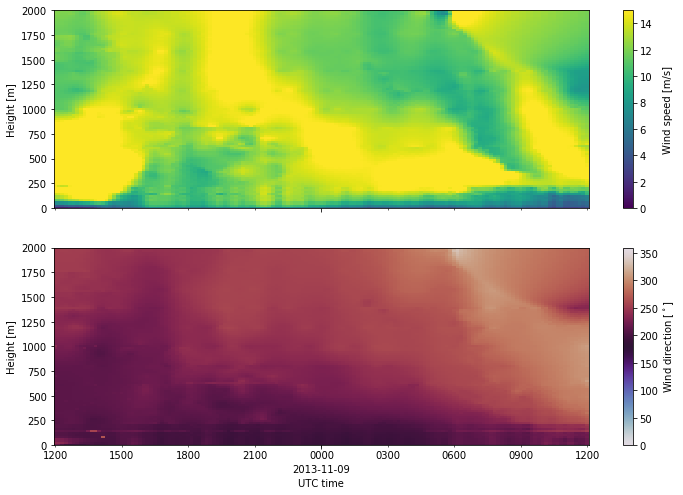

In [63]:
fig,ax,cbars = plot_timeheight(df,
                               fields='all',
                               fieldlimits={'wspd':(0,15), 'wdir':(0,360)})
fig.savefig(os.path.join(fig_output,'all_data_NNinterp.png'),
            dpi=150,bbox_inches='tight')

### manual quality controlled data
Performed using `manual_qc.py` tool from https://github.com/ewquon/analysis/blob/master/swift/manual_qc.py

In [64]:
# qcdata = pd.read_csv('data/combined_radar_data_qc.csv',parse_dates=['datetime'])
# xi_qc = qcdata['t_index']
# yi_qc = qcdata['height']
# zi_qc = np.zeros(len(xi_qc))
# points = np.stack((xi_qc,yi_qc,zi_qc),axis=-1)
# wspd_interp_qc = naturalneighbor.griddata(points, qcdata['wspd'], griddef).squeeze()
# wdir_interp_qc = naturalneighbor.griddata(points, qcdata['wdir'], griddef).squeeze()

## Analyze temperature data
*Not* analyzed in detail during the period of interest due to the limited quantity/quality of data

In [65]:
rass_times = rass.index.levels[0]
rass_heights = rass.index.levels[1]
tt,zz = np.meshgrid(rass_times,rass_heights,indexing='ij')

(0, 1000)

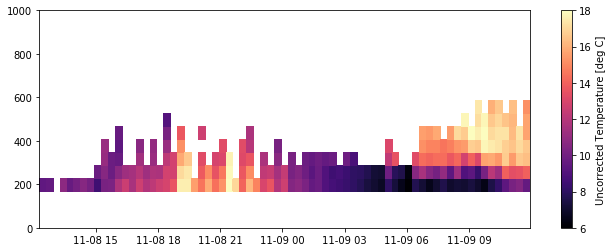

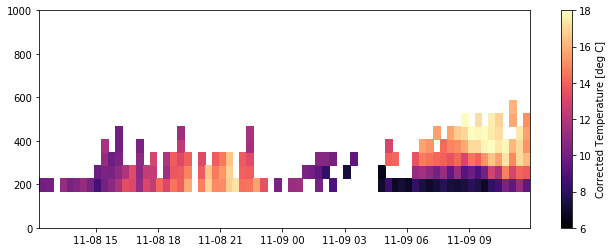

In [66]:
vmin,vmax = 6,18
cmap = 'magma'
zrange = (0,1000)

fig,ax = plt.subplots(figsize=(11,4))
pcm = ax.pcolormesh(tt,zz,rass['T'].unstack(),
                    cmap=cmap,vmin=vmin,vmax=vmax)
cbar = fig.colorbar(pcm)
cbar.set_label('Uncorrected Temperature [deg C]')
ax.set_ylim(zrange)

fig,ax = plt.subplots(figsize=(11,4))
pcm = ax.pcolormesh(tt,zz,rass['Tc'].unstack(),
                    cmap=cmap,vmin=vmin,vmax=vmax)
cbar = fig.colorbar(pcm)
cbar.set_label('Corrected Temperature [deg C]')
ax.set_ylim(zrange)